# NE204 Lab 2

## Importing libraries and defining functions

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

In [99]:
def ViewPulses(filelocation, events, XRange, preTrgrDly):
    with h5py.File(filelocation, 'r') as f:
        for a in range(events):
            pulse = np.array(f['raw_data'][a])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            plt.plot(range(XRange[0], XRange[1]), pulse[XRange[0]:XRange[1]])
        plt.xlabel("Counts (4 nanoseconds per)")
        plt.ylabel("Units proportional to voltage")

def CreateSpectra(filelocation, events, preTrgrDly, risetime):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        for a in range(events):
            pulse = np.array(f['raw_data'][a])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            sum = np.sum(pulse[preTrgrDly-100:preTrgrDly+risetime-100])
            if sum > 0:
                spectra.append(sum)
        return(spectra)

def CreateSpectra_reject(filelocation, events, preTrgrDly, risetimefast, risetimeslow):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        a = 0
        while len(spectra) < events:
            pulse = np.array(f['raw_data'][a])  # type: ignore
            a += 1
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            sum_list = []
            numberofsections = risetimeslow//risetimefast
            for i in range(numberofsections):
                sum_list.append(np.sum(pulse[preTrgrDly-100+risetimefast*i:preTrgrDly-100+risetimefast*(i+1)]))
            if sum_list[int(100/risetimefast)] > np.sum(sum_list[int(100/risetimefast)+1:]):
                spectra.append(np.sum(sum_list))
        return(spectra)

def Gaussian(x, a, b, c, d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d

def InverseRoot(x, a):
    return a/(x**0.5)

def Linear(x, a, b):
    return a*x+b

def PeakInfo(hist, d, promF):
    peaklocations, _ = find_peaks(hist, distance=d, prominence=int(np.amax(hist))/promF)
    widths = peak_widths(hist, peaklocations, rel_height=0.5)
    Xranges = []
    coefficients = []
    numberofpeaks = 0
    FWHMs = []
    for i in range(len(peaklocations)):
        try:
            left = int(peaklocations[i]-widths[0][i])
            right = int(peaklocations[i]+widths[0][i])
            x = np.linspace(left, right, right-left)
            popt, pcov = curve_fit(Gaussian, x, hist[left:right], [hist[peaklocations[i]], peaklocations[i], widths[0][i], 0])
            popt[2] = np.abs(popt[2])
            Xranges.append(x)
            coefficients.append(popt)
            numberofpeaks += 1
            FWHMs.append(widths[0][i])
        except:
            pass
    return Xranges, coefficients, numberofpeaks, FWHMs


## Plotting raw raveforms

Specifying that rise time starts 100 before trigger (preTrgrDly-100)

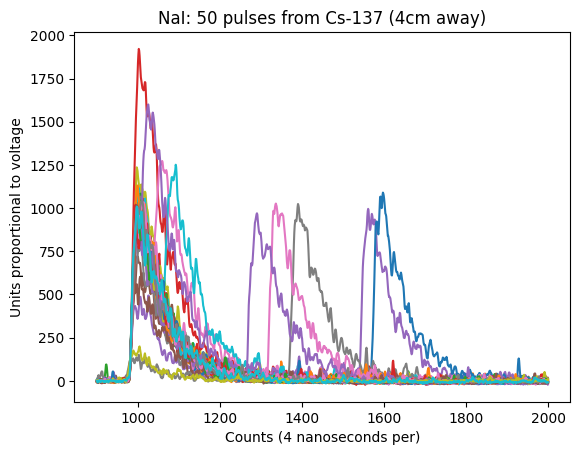

In [58]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
events = 50
XRange = (900,2000)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (4cm away)')
plt.show()

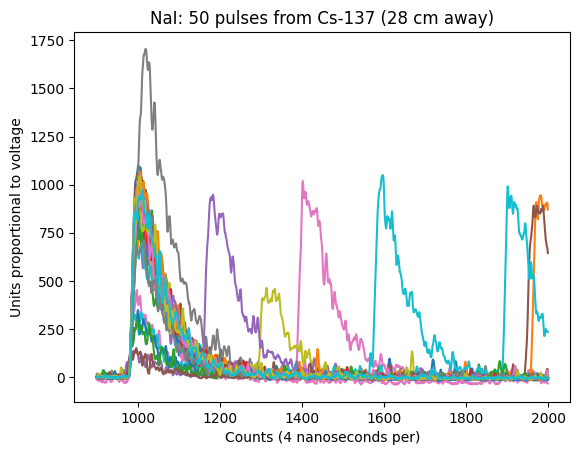

In [43]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 50
XRange = (900,2000)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (28 cm away)')
plt.show()

The initial pulses generally decay mostly away by about 300 counts after the trigger (1.2 microseconds), so I will use 400 as the initial guess for rise time. Don't see much of a difference in pile-up rate between 4 and 28 cm away however. Noting that since the pulse heights seem to average around 1000, integrating over 400 counts would give pulses that are almost all under 400*1000 = 400000. So I will set the histogram range to 0, 400000

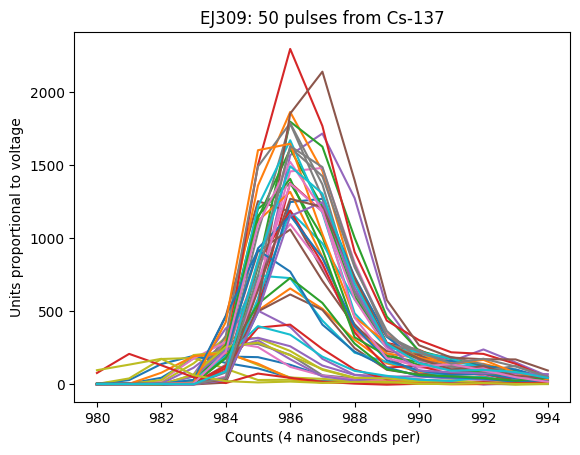

In [5]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ309_Cs137_60s.h5"
events = 50
XRange = (980,995)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('EJ309: 50 pulses from Cs-137')
plt.show()

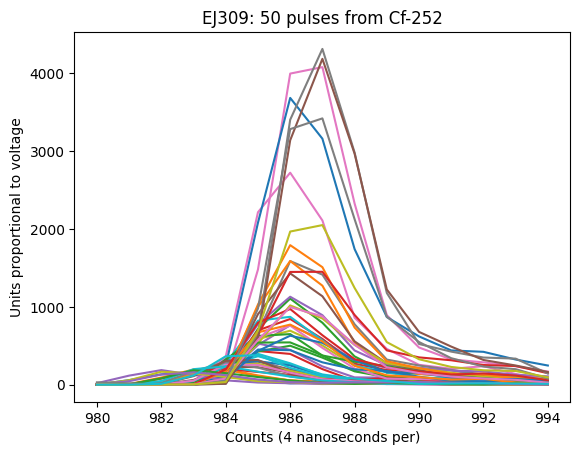

In [6]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ309_Cf252_60s.h5"
events = 50
XRange = (980,995)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('EJ309: 50 pulses from Cf-252')
plt.show()

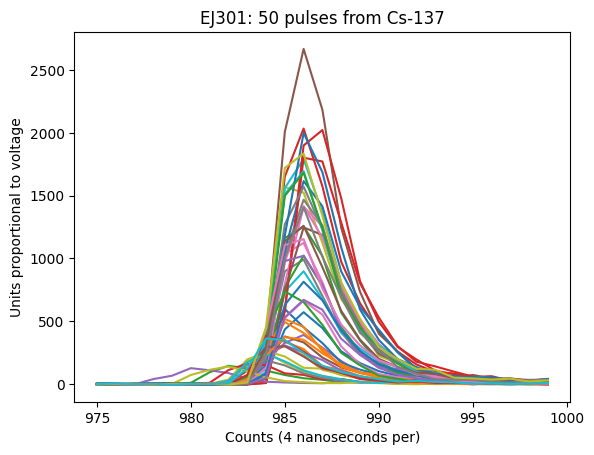

In [7]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ301_Cs137_60s.h5"
events = 50
XRange = (975,1000)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('EJ301: 50 pulses from Cs-137')
plt.show()

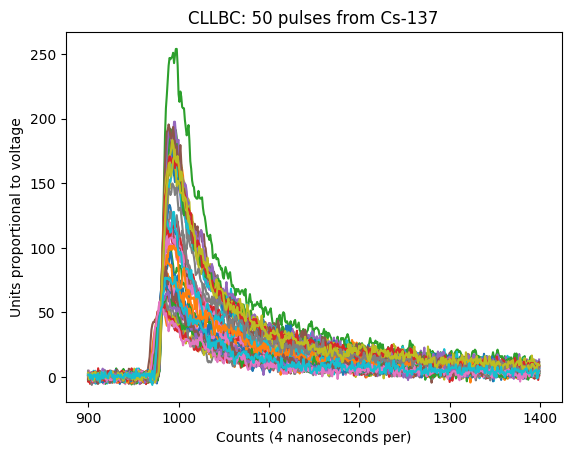

In [8]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\CLLBC_Cs137_180s.h5"
events = 50
XRange = (900,1400)
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('CLLBC: 50 pulses from Cs-137')
plt.show()

Will have to return to lab to get more data with CLLBC, did not capture the whole decay with 1100 counts per event. 

## Analyzing NaI Cs-137 Data to find optimal integration period

1225188.3333333333
Centroid is at: 427.7
FWHM is: 32.17
% Resolution = 7.521


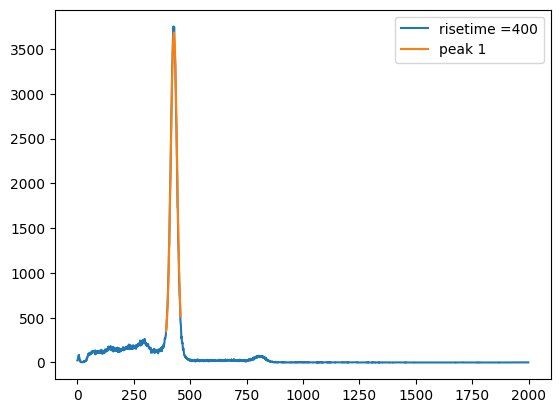

In [59]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 200000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 10
risetime = 400
spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
print(np.max(spectra))
hist, bins = np.histogram(spectra, bins = 2000, range = (0, 400000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.legend(loc='upper right')
plt.show()

Seems like the range can be decreased to half of before. Noting that the maximum of the spectra has a value of 1,110,000. 

Centroid is at: 352.6
FWHM is: 27.64
% Resolution = 7.838
Centroid is at: 430.8
FWHM is: 34.03
% Resolution = 7.899


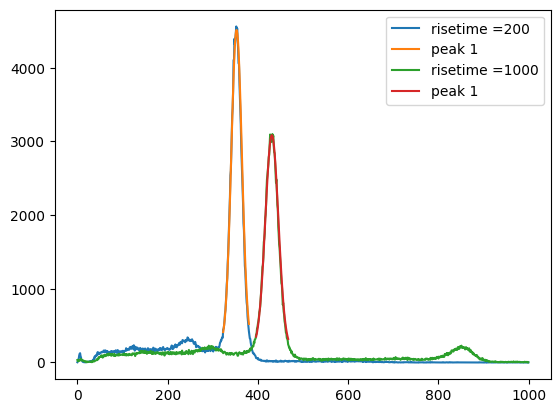

In [60]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
risetime = 200

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
risetime = 1000

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.legend(loc='upper right')
plt.show()

In [11]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"

data = []
for a in range(5):
    row = []
    events = 200000
    preTrgrDly = 1000
    prominencefactor = 10
    risetime = 100*(a+2)
    spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
    for b in range(15):
        resolutions = []
        peakdistance = 3*(b+1)
        hist, bins = np.histogram(spectra, bins = 2000*(b+1))
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=100*(np.array(range(5))+2), columns=2000*(np.array(range(15))+1))
df.style.background_gradient(axis=None)



c:\Users\devth\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,2000,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000,24000,26000,28000,30000
200,7.994978,7.854058,7.818428,7.842116,7.847678,7.841168,7.745625,7.748283,7.741281,3.883447,4.089084,7.821270,19.501601,15.697453,3.982256
300,7.826978,7.653059,7.603335,7.533126,7.520938,7.560339,7.500881,7.544482,7.522014,7.541858,7.512705,7.528829,7.546134,7.526314,7.533222
400,7.779087,7.593261,7.521568,7.530605,7.475699,7.461064,7.442144,7.430814,7.425630,7.417825,7.417556,7.417893,7.411465,7.426342,7.401693
500,7.777270,7.641825,7.601762,7.582422,7.581613,7.568275,7.541268,7.530916,7.536868,7.523172,7.521827,7.528816,7.521285,7.516422,7.522296
600,7.886202,7.715990,7.649851,7.634277,7.628749,7.563669,7.572165,7.540119,7.562183,7.558797,7.470012,7.467315,7.465758,7.476683,7.548269


Comparing integration periods of 200 and 1000 counts, the spectra created from a longer rise time will have a photopeak that shows up further to the right on the graph since more of the pulse is integrated over. Setting the integration period to 1000 shows a second peak at twice the magnitude, due to integrating over two pulses. 

With 1000 bins for a range of 200000, equivalent bin size for a full range of values (up to 1110000) would require ~6000 bins.

In [12]:
filelocations = [ 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_12cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_16cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_20cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_24cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5",
    ]

filenames = []
data = []
for a in filelocations:
    row = []
    filelocation = a
    filenames.append(os.path.split(a)[1])
    events = 200000
    preTrgrDly = 1000
    peakdistance = 30
    prominencefactor = 10
    for b in range(9):
        resolutions = []
        risetime = 100*(b+2)
        spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
        hist, bins = np.histogram(spectra, bins = 10000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=filenames, columns=100*(np.array(range(9))+2))
df.style.background_gradient(axis=None)



,200,300,400,500,600,700,800,900,1000
NaI_Cs137_4cm_30.h5,7.928061,7.573654,7.494098,7.413913,7.397385,7.526697,7.853346,7.954709,8.129391
NaI_Cs137_8cm_30.h5,7.699420,7.572308,7.583930,7.573755,7.588877,7.715653,7.695665,7.813411,8.017342
NaI_Cs137_12cm_30.h5,7.574912,7.384695,7.458372,7.619792,7.624322,7.652394,7.738898,7.769401,7.707316
NaI_Cs137_16cm_30.h5,7.686339,7.564084,7.383256,7.577919,7.545408,7.640597,7.717866,7.907897,8.062872
NaI_Cs137_20cm_30.h5,7.793565,7.383706,7.376863,7.435735,7.521633,7.522841,7.670947,7.784275,7.812013
NaI_Cs137_24cm_30.h5,7.731296,7.576826,7.482008,7.546932,7.556734,7.598589,7.697034,7.773003,7.832845
NaI_Cs137_28cm_30.h5,7.847678,7.520938,7.475699,7.581613,7.628749,7.624363,7.669751,7.771463,7.871687


This heatmap of the resolutions of the Cs-137 662 keV peak show that generally, optimal resolution results from integrating the pulse over 400 counts, starting from 100 counts before the trigger. One can see that rise times that are especially long (between 800 and 1000 counts) impair resolution the most for the data taken with the source 4 cm away.

For 200000 events per, this process took 49 minutes.

## Pile up rejection

Centroid is at: 430.3
FWHM is: 34.08
% Resolution = 7.919
Centroid is at: 430.6
FWHM is: 33.91
% Resolution = 7.876


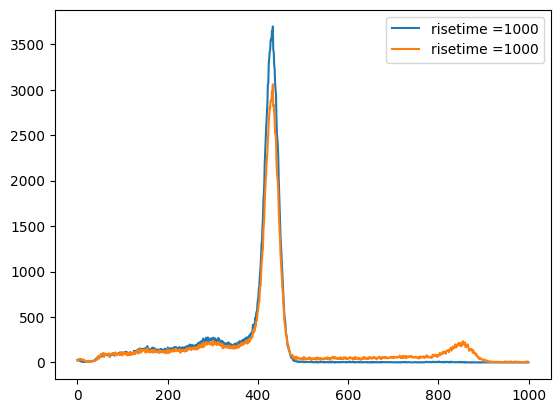

In [102]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
risetimefast = 50
risetimeslow = 1000
events = 200000

spectra = CreateSpectra_reject(filelocation, events, preTrgrDly, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetimeslow))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(FWHMs[i])[:5])
    print("% Resolution = " + str(100*FWHMs[i]/coefficients[i][1])[:5])

risetime = 1000

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(FWHMs[i])[:5])
    print("% Resolution = " + str(100*FWHMs[i]/coefficients[i][1])[:5])

plt.legend(loc='upper right')
plt.show()

Centroid is at: 426.5
FWHM is: 32.25
% Resolution = 7.561
Centroid is at: 426.6
FWHM is: 32.13
% Resolution = 7.532


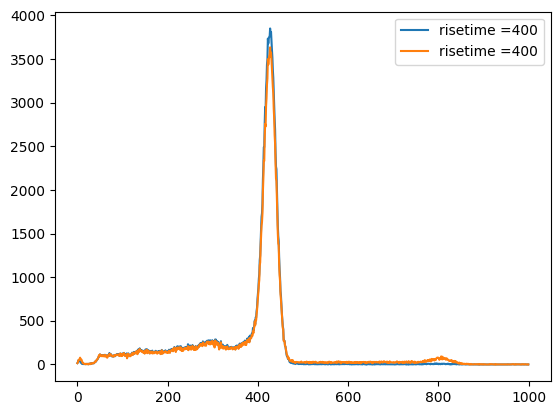

In [103]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
risetimefast = 50
risetimeslow = 400

spectra = CreateSpectra_reject(filelocation, events, preTrgrDly, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetimeslow))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(FWHMs[i])[:5])
    print("% Resolution = " + str(100*FWHMs[i]/coefficients[i][1])[:5])

risetime = 400

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(FWHMs[i])[:5])
    print("% Resolution = " + str(100*FWHMs[i]/coefficients[i][1])[:5])

plt.legend(loc='upper right')
plt.show()

## Measuring energy resolutions

In [27]:
total_peakinfo = []
energies = []

Will add to this list to create energy calibration

Centroid is at: 623.9
FWHM is: 29.50
% Resolution = 4.729
Centroid is at: 695.2
FWHM is: 28.46
% Resolution = 4.093


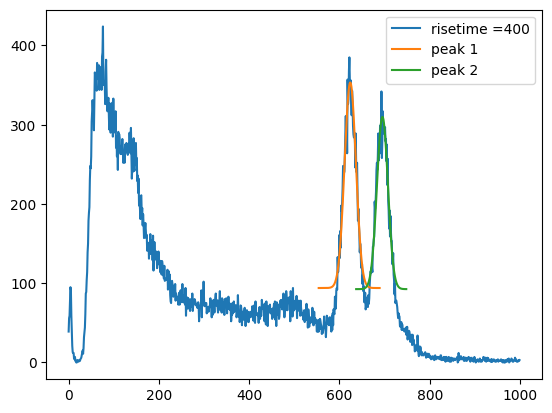

In [96]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Co60_120s.h5"
risetime = 400
peakdistance = 30
prominencefactor = 5
peakinfo = []

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.legend(loc='upper right')
plt.show()

In [29]:
print(peakinfo)
total_peakinfo.extend(peakinfo)
energies.extend([1173.2, 1332.5])

[[623.8054036459797, 5.701021441413923], [695.6019502952266, 5.149844036319371]]


Centroid is at: 81.17
FWHM is: 10.97
% Resolution = 13.51
Centroid is at: 151.3
FWHM is: 13.48
% Resolution = 8.908
Centroid is at: 210.6
FWHM is: 20.77
% Resolution = 9.860
Centroid is at: 442.0
FWHM is: 30.21
% Resolution = 6.834
Centroid is at: 532.7
FWHM is: 28.61
% Resolution = 5.372
Centroid is at: 597.5
FWHM is: 35.22
% Resolution = 5.894
Centroid is at: 738.2
FWHM is: 46.43
% Resolution = 6.290


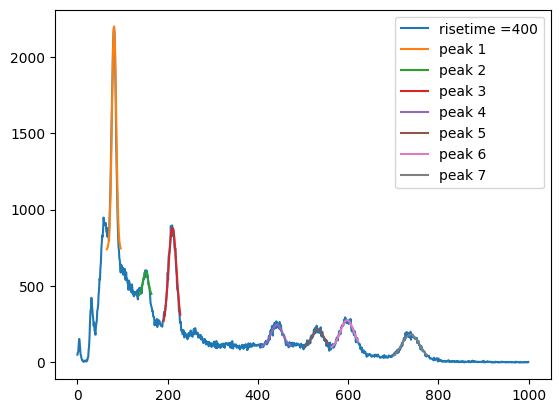

In [30]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Eu152_120s.h5"
prominencefactor = 20
peakinfo = []

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.legend(loc='upper right')
plt.show()

In [31]:
print(peakinfo)
total_peakinfo.extend(peakinfo)
energies.extend([121.8, 244.7, 344.3, 778.9, 964.1, 1112.1, 1408])

[[81.17799206779159, 13.514123088691678], [151.35455681250173, 8.908500260292232], [210.66025530306644, 9.86021612003379], [442.04195684956824, 6.834382023475972], [532.7297095460299, 5.372220452768607], [597.5745924040463, 5.894078428654194], [738.2388556863556, 6.29020902926612]]


Centroid is at: 113.2
FWHM is: 592.5
% Resolution = 523.2
Centroid is at: 302.1
FWHM is: 26.08
% Resolution = 8.634
Centroid is at: 676.7
FWHM is: 39.09
% Resolution = 5.777


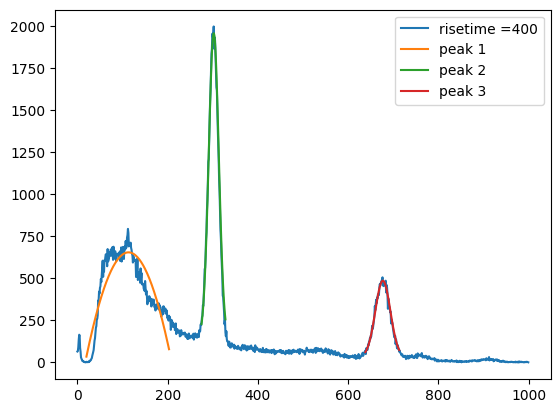

In [32]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Na22_120s.h5"
prominencefactor = 10
peakinfo = []

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.legend(loc='upper right')
plt.show()

Will not add peaks 1 and 2 to list (511 keV peak should not be used)

In [33]:
print(peakinfo[2:])
total_peakinfo.extend(peakinfo[2:])
energies.extend([1274.5])

[[676.7604402344601, 5.777372586812427]]


Centroid is at: 55.68
FWHM is: 9.387
% Resolution = 16.85
Centroid is at: 97.08
FWHM is: 31.23
% Resolution = 32.17
Centroid is at: 184.2
FWHM is: 17.82
% Resolution = 9.678
Centroid is at: 216.3
FWHM is: 20.24
% Resolution = 9.358


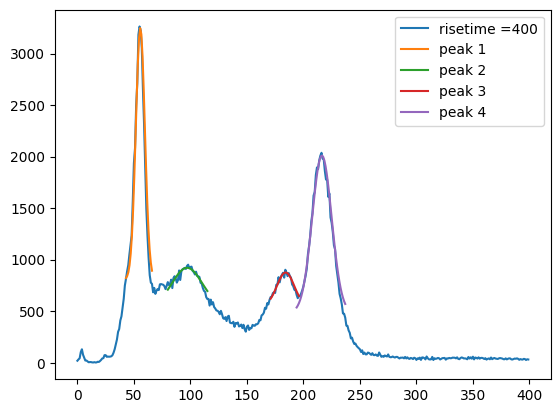

In [34]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Ba133_120s.h5"
prominencefactor = 15
peakinfo = []

spectra = CreateSpectra(filelocation, events, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 400, range = (0,80000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.legend(loc='upper right')
plt.show()

I don't believe the second peak is a gamma peak

In [35]:
del peakinfo[1]
print(peakinfo)
total_peakinfo.extend(peakinfo)
energies.extend([81, 302, 356])

[[55.68281645715924, 16.8581141041818], [184.22168223979403, 9.678464712003738], [216.36541755223828, 9.358290289917774]]


y = 1.959*x + -54.3


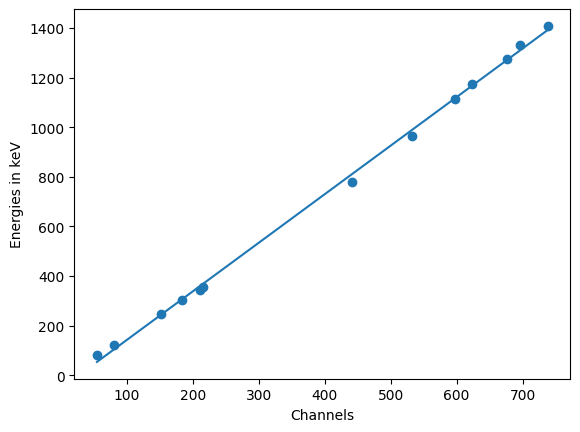

In [36]:
all_peaks = np.array(total_peakinfo)[:,0]
plt.scatter(all_peaks, energies)
popt, pcov = curve_fit(Linear, np.array(total_peakinfo)[:,0], energies)
print("y = "+str(popt[0])[:5]+"*x + "+str(popt[1])[:5])
x = np.linspace(int(np.min(all_peaks)), int(np.max(all_peaks)), int(np.max(all_peaks)-np.min(all_peaks)))
vLinear = np.vectorize(Linear)
all_energies = vLinear(all_peaks, *popt)
plt.plot(x, Linear(x, *popt))
plt.xlabel("Channels")
plt.ylabel("Energies in keV")
plt.show()


y = 148.1/x**0.5


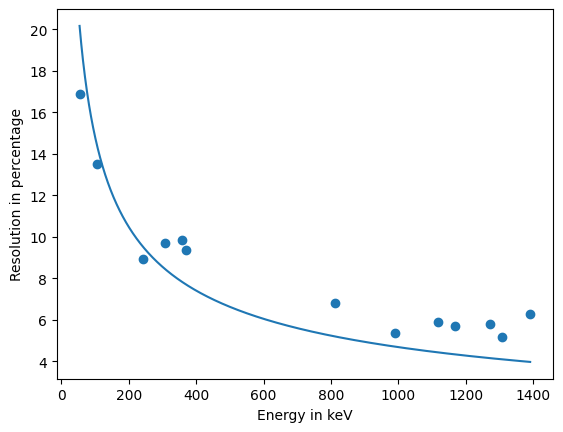

In [37]:
all_resolutions = np.array(total_peakinfo)[:,1]
plt.scatter(all_energies, all_resolutions)
popt, pcov = curve_fit(InverseRoot, all_energies, all_resolutions)
print("y = "+str(popt[0])[:5]+"/x**0.5")
x = np.linspace(int(np.min(all_energies)), int(np.max(all_energies)), int(np.max(all_energies)-np.min(all_energies)))
plt.plot(x, InverseRoot(x, *popt))
plt.ylabel("Resolution in percentage")
plt.xlabel("Energy in keV")
plt.show()

Resolution should be proportional to the inverse square root of energy for purely Poission statistics. Non-proportionality can possibly explain the worse resolution above the fitted inverse square root curve higher than 600 keV.

y = -0.34*x + 4.228


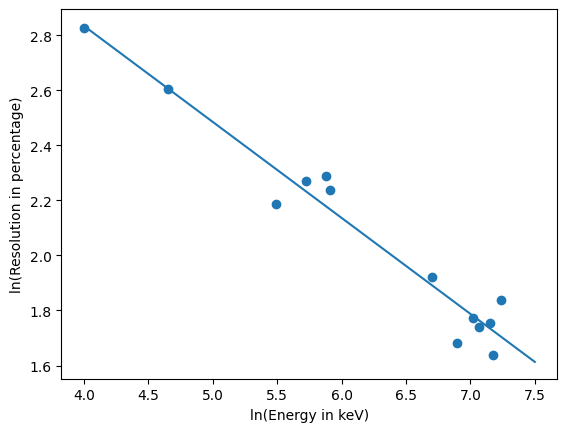

In [41]:
plt.scatter(np.log(all_energies), np.log(all_resolutions))
popt, pcov = curve_fit(Linear, np.log(all_energies), np.log(all_resolutions))
print("y = "+str(popt[0])[:5]+"*x + "+str(popt[1])[:5])
x = np.linspace(4, 7.5, 100)
plt.plot(x, Linear(x, *popt))
plt.ylabel("ln(Resolution in percentage)")
plt.xlabel("ln(Energy in keV)")
plt.show()